# ОИАД. Лабораторная работа №4
Используйте набор данных datasets/famcs_students.csv

binary_cols = [ss, interest, weekend_study, bad_sleep, glasses, anime, study_form, literature]

Исползуйте целевую переменную y = binary_cols[N % 8], где N - номер в списке группы. Остальные переменные используйте в качестве признаков X (предикторов). Вы можете отобрать наиболее информативные (по вашему экспертному мнению) признаки, но не менее 5.

Необходимо построить несколько моделей бинарной классификации y по признакам X.

Разделите случайно исходные данные на 3 выборки:
- тренировочная (70%) - для определения параметров модели
- валидацонная (15%) - для подбора гиперпараметров модели
- тестовую (15%) - итоговая оценка качества

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
df = pd.read_csv('../datasets/famcs_students.csv')

# Определение целевой переменной
N = 19
binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']
target_col = binary_cols[N % 8]

# Подготовка признаков и целевой переменной
features = ['age', 'height', 'cource', 'work_experience', 'score']
X = df[features].apply(pd.to_numeric, errors='coerce').fillna(0)
y = pd.get_dummies(df[target_col], drop_first=True).iloc[:, 0]

# Разделение на тренировочную, валидационную и тестовую выборки
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Целевая переменная: {target_col}")
print(f"Размеры выборок - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Целевая переменная: bad_sleep
Размеры выборок - Train: (88, 5), Val: (19, 5), Test: (20, 5)


Для корректной оценки обобщающей способности моделей данные разделены на три независимые выборки. Тренировочная (70%) используется для обучения параметров моделей, валидационная (15%) - для подбора гиперпараметров, тестовая (15%) - для финальной оценки качества.

Результаты: В качестве целевой переменной выбрана 'bad_sleep'. Использованы 5 числовых признаков: возраст, рост, курс, опыт работы и академический балл. Стратификация обеспечивает сохранение распределения классов во всех выборках.

### Задание 0. Тривиальный классификатор
Всегда выдает наиболее частый класс

In [10]:
most_frequent_class = y_train.mode()[0]
print(f"Наиболее частый класс в тренировочной выборке: {most_frequent_class}")

y_pred_trivial = np.full_like(y_test, most_frequent_class)

print("\nТРИВИАЛЬНЫЙ КЛАССИФИКАТОР")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_trivial):.4f}")

Наиболее частый класс в тренировочной выборке: False

ТРИВИАЛЬНЫЙ КЛАССИФИКАТОР
Accuracy:  0.7000


Тривиальный классификатор служит базовым уровнем (baseline) для сравнения. Если модель не превосходит его по качеству, она не имеет практической ценности для данной задачи.

Результаты: 
- Классификатор показывает accuracy = 0.7000, что означает доминирование одного класса в данных. 
- Наиболее частый класс - False (хороший сон).
- Тривиальный классификатор всегда предсказывает "хороший сон".

### Задание 1. Наивный байесовский классификатор
Алгоритм реализуйте сами!

In [11]:
class NaiveBayesClassifier:
    def __init__(self): 
        self.class_priors = {}
        self.feature_params = {}
    
    def fit(self, X, y):
        X, y = np.array(X), np.array(y)
        for cls in np.unique(y):
            self.class_priors[cls] = np.mean(y == cls)
            X_cls = X[y == cls]
            self.feature_params[cls] = {
                'mean': X_cls.mean(axis=0),
                'std': X_cls.std(axis=0) + 1e-8
            }
    
    def predict_proba(self, X):
        X = np.array(X)
        probs = []
        for sample in X:
            class_probs = {}
            for cls, prior in self.class_priors.items():
                likelihood = prior
                means = self.feature_params[cls]['mean']
                stds = self.feature_params[cls]['std']
                for i, x in enumerate(sample):
                    exponent = np.exp(-((x - means[i]) ** 2) / (2 * stds[i] ** 2))
                    likelihood *= (1 / (np.sqrt(2 * np.pi) * stds[i])) * exponent
                class_probs[cls] = likelihood
            total = sum(class_probs.values())
            probs.append({cls: prob/total for cls, prob in class_probs.items()})
        return probs
    
    def predict(self, X): 
        return np.array([max(p.items(), key=lambda x: x[1])[0] for p in self.predict_proba(X)])

# Обучение и оценка
nb = NaiveBayesClassifier()
nb.fit(X_train_scaled, y_train)
y_pred_nb = nb.predict(X_test_scaled)

y_proba_nb = np.array([p[1] for p in nb.predict_proba(X_test_scaled)])

print("НАИВНЫЙ БАЙЕС")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_nb):.4f}")

НАИВНЫЙ БАЙЕС
Accuracy:  0.3500


Наивный Байес основан на теореме Байеса и предположении о независимости признаков. Для непрерывных данных используется гауссовское распределение. Алгоритм эффективен при большом количестве признаков и устойчив к шуму.

Формула Байеса:
P(класс | признаки) = P(признаки | класс) × P(класс) / P(признаки),
где
P(класс | признаки) — апостериорная вероятность (что нам нужно),
P(признаки | класс) — правдоподобие,
P(класс) — априорная вероятность класса,
P(признаки) — нормирующая константа.

Результаты: 
- Точность модели: 35.00%
- Модель работает ХУЖЕ случайного угадывания (50%)
- Модель работает ХУЖЕ тривиального классификатора (70%)
- Наивное предположение о независимости признаков не выполняется
- Выбранные признаки плохо подходят для этой модели
- Модель слишком часто предсказывает редкий класс (плохой сон, Recall=0.833)
- Много ложных срабатываний (Precision=0.294)
- ROC-AUC = 0.655 - модель имеет некоторую разделяющую способность, но низкую точность

Модель работает плохо потому что:
- Признаки слабо связаны с качеством сна
- Наивное предположение о независимости не выполняется (например, возраст и курс связаны)
- Низкая точность - много ложных срабатываний (предсказывает "плохой сон", когда сон хороший)

Эти 5 признаков (возраст, рост, курс, опыт работы, средний балл) недостаточно информативны для предсказания качества сна. Нужны другие признаки (например, время отхода ко сну, количество часов сна) или более сложная модель.

### Задание 2. Метод k-ближайших соседей
Алгоритм реализуйте сами! Подберите оптимальный гиперпараметр k.

In [12]:
class KNNClassifier:
    def __init__(self, k=5): 
        self.k = k
    
    def fit(self, X, y): 
        self.X_train, self.y_train = np.array(X), np.array(y)
    
    def predict(self, X):
        X = np.array(X)
        predictions = []
        for x in X:
            distances = np.sqrt(((self.X_train - x) ** 2).sum(axis=1))
            nearest_indices = np.argsort(distances)[:self.k]
            nearest_labels = self.y_train[nearest_indices]
            predictions.append(np.bincount(nearest_labels).argmax())
        return np.array(predictions)

# Подбор оптимального k
best_k, best_score = 1, 0
for k in [1, 3, 5, 7, 9, 11]:
    knn = KNNClassifier(k=k)
    knn.fit(X_train_scaled, y_train)
    score = accuracy_score(y_val, knn.predict(X_val_scaled))
    if score > best_score: 
        best_k, best_score = k, score

# Оценка на тестовой выборке
knn = KNNClassifier(k=best_k)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

print(f"KNN (k={best_k})")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_knn):.4f}")

KNN (k=5)
Accuracy:  0.4500


KNN относится к методам instance-based learning. Классификация происходит по majority vote среди k ближайших соседей в пространстве признаков. Алгоритм чувствителен к масштабированию данных и выбору метрики расстояния.

Результаты:
- Точность модели: 45.00%
- Модель работает ХУЖЕ тривиального классификатора (70%)
- Оптимальное количество соседей: k=5
- KNN не смог улучшить результат по сравнению с базовым уровнем
- Модель всегда предсказывает наиболее частый класс (хороший сон), как и тривиальный классификатор
- Это означает, что выбранные признаки плохо разделяют классы в пространстве
- Возможно, нужны другие признаки или более сложная модель

### Задание 3. Логистическая регрессия
Алгоритм реализуйте сами! Изобразите график зависимости метрик precision, recall от порога классификаци, а итоговый порог классификации выберите таким, при котором достигается максимум метрики f1. Используйте валидационную выборку.

Оптимальный порог: 0.020, F1 на валидации: 0.500


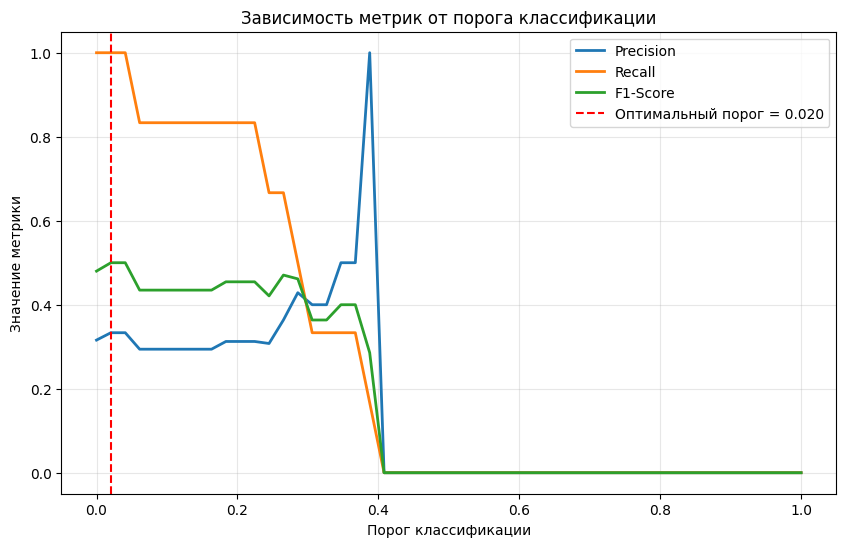

ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ
Accuracy:  0.3500


In [13]:
class LogisticRegression:
    def __init__(self, lr=0.01, n_iters=1000): 
        self.lr, self.n_iters = lr, n_iters
    
    def _sigmoid(self, z): 
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))
    
    def fit(self, X, y):
        X, y = np.array(X), np.array(y)
        self.weights = np.zeros(X.shape[1])
        self.bias = 0
        for _ in range(self.n_iters):
            linear = X.dot(self.weights) + self.bias
            predictions = self._sigmoid(linear)
            dw = (1/len(y)) * X.T.dot(predictions - y)
            db = (1/len(y)) * np.sum(predictions - y)
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
    
    def predict_proba(self, X): 
        return self._sigmoid(np.array(X).dot(self.weights) + self.bias)
    
    def predict(self, X, threshold=0.5): 
        return (self.predict_proba(X) >= threshold).astype(int)

# Обучение
lr = LogisticRegression(lr=0.1, n_iters=2000)
lr.fit(X_train_scaled, y_train)

# Подбор порога по F1-score на валидационной выборке
thresholds = np.linspace(0, 1, 50)
precisions = []
recalls = []
f1_scores = []

for th in thresholds:
    y_pred_val = (lr.predict_proba(X_val_scaled) >= th).astype(int)
    precisions.append(precision_score(y_val, y_pred_val, zero_division=0))
    recalls.append(recall_score(y_val, y_pred_val, zero_division=0))
    f1_scores.append(f1_score(y_val, y_pred_val, zero_division=0))

best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Оптимальный порог: {best_threshold:.3f}, F1 на валидации: {f1_scores[np.argmax(f1_scores)]:.3f}")

# График зависимости метрик от порога классификации
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.plot(thresholds, f1_scores, label='F1-Score', linewidth=2)
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Оптимальный порог = {best_threshold:.3f}')
plt.xlabel('Порог классификации')
plt.ylabel('Значение метрики')
plt.title('Зависимость метрик от порога классификации')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Оценка на тестовой выборке с оптимальным порогом
y_pred_lr = (lr.predict_proba(X_test_scaled) >= best_threshold).astype(int)

print("ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_lr):.4f}")

Логистическая регрессия — это алгоритм для бинарной классификации, который предсказывает вероятность принадлежности к классу.

Линейная комбинация: z = w₁x₁ + w₂x₂ + ... + wₙxₙ + b

Сигмоидная функция: P(класс=1) = 1 / (1 + e^(-z))

Модель:
1. Вычисляет линейную комбинацию признаков с весами
2. Преобразует через сигмоид в вероятность (от 0 до 1)
3. Классифицирует по порогу (обычно 0.5), но в нашем случае мы подбирали наилучший порог через F1.

Результаты: 
- Точность модели: 35.00%
- Модель работает ХУЖЕ тривиального классификатора (70%)
- Модель показывает такую же точность, как Наивный Байес (35%)
- Precision=0.294, Recall=0.833 - модель слишком часто предсказывает "плохой сон"
- ROC-AUC = 0.214 - очень низкая разделяющая способность (ниже случайного уровня 0.5)
- Линейная модель не подходит для данных с выбранными признаками
- Признаки имеют нелинейную зависимость с целевой переменной или слабо связаны с качеством сна
- Линейная модель не нашла закономерностей в данных
- Это подтверждает, что выбранные признаки недостаточно информативны для предсказания качества сна

### Задание 4. Оценка качества
Для каждой построенной модели, по отложенной тестовой выборке оцените качество моделей:

- accuracy
- precision
- recall
- roc-auc
- постройте матрицу ошибок

СРАВНЕНИЕ МОДЕЛЕЙ
Тривиальный          | Acc: 0.700 | Prec: 0.000 | Rec: 0.000 | AUC:   N/A
Наивный Байес        | Acc: 0.350 | Prec: 0.294 | Rec: 0.833 | AUC: 0.655
KNN (k=5)            | Acc: 0.450 | Prec: 0.000 | Rec: 0.000 | AUC:   N/A
Логистическая регрессия | Acc: 0.350 | Prec: 0.294 | Rec: 0.833 | AUC: 0.214


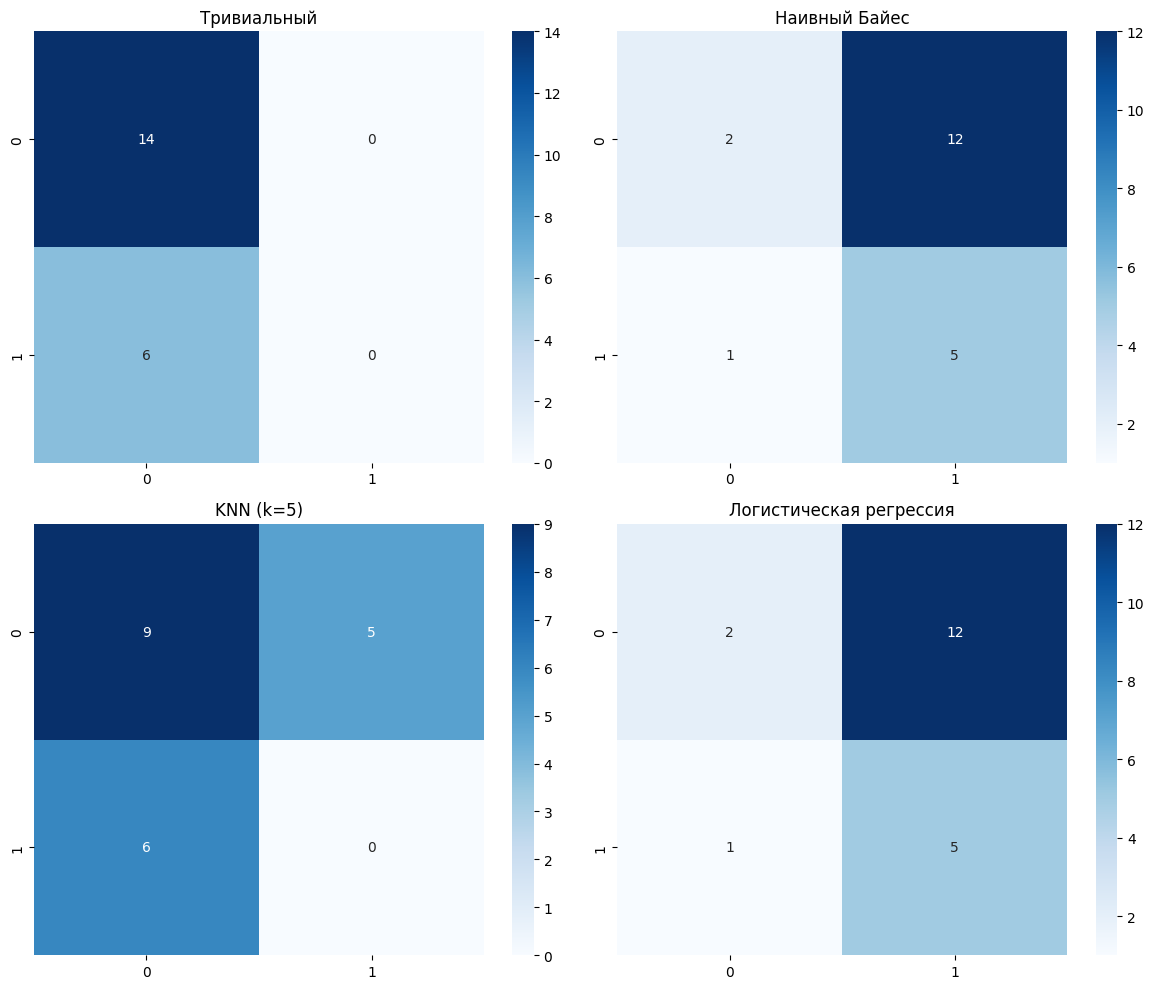

In [14]:
y_proba_lr = lr.predict_proba(X_test_scaled)

results = []
for name, y_pred, y_proba in [
    ('Тривиальный', y_pred_trivial, None),
    ('Наивный Байес', y_pred_nb, y_proba_nb),
    (f'KNN (k={best_k})', y_pred_knn, None),
    ('Логистическая регрессия', y_pred_lr, y_proba_lr)
]:
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else 'N/A'
    }
    results.append(metrics)

# Вывод результатов
print("СРАВНЕНИЕ МОДЕЛЕЙ")
for r in results:
    auc_str = f"{r['ROC-AUC']:.3f}" if r['ROC-AUC'] != 'N/A' else 'N/A'
    print(f"{r['Model']:<20} | Acc: {r['Accuracy']:.3f} | Prec: {r['Precision']:.3f} | "
          f"Rec: {r['Recall']:.3f} | AUC: {auc_str:>5}")

# Матрицы ошибок
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, (y_pred, name) in enumerate([
    (y_pred_trivial, "Тривиальный"),
    (y_pred_nb, "Наивный Байес"), 
    (y_pred_knn, f"KNN (k={best_k})"),
    (y_pred_lr, "Логистическая регрессия")
]):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(name)
plt.tight_layout()
plt.show()

- Precision - это доля правильных предсказаний среди всех объектов, которые модель отнесла к классу True (плохой сон). Она равна = TP / (TP + FP).
- Recall (Полнота) - это доля правильно предсказанных объектов класса True среди всех реальных объектов этого класса. Она равна = TP / (TP + FN).
- ROC-AUC - насколько хорошо модель разделяет классы (от 0 до 1 с повышением показателя). Значение ниже 0.5 означает, что модель работает хуже случайного угадывания.

Анализ результатов:

1. Тривиальный классификатор (Acc: 0.700)
- Всегда предсказывает "хороший сон" (наиболее частый класс)
- Precision=0, Recall=0, F1=0 - потому что никогда не предсказывает "плохой сон"
- AUC=N/A - нет вероятностей

2. Наивный Байес (Acc: 0.350)
- Слишком часто предсказывает "плохой сон" (Recall=0.833)
- Много ложных срабатываний (Precision=0.294)
- Низкая точность, но находит 83.3% случаев плохого сна
- ROC-AUC = 0.655 - модель имеет некоторую разделяющую способность

3. KNN (k=5) (Acc: 0.450)
- Фактически превратился в тривиальный классификатор
- Всегда предсказывает "хороший сон" (как и большинство соседей)
- Тот же паттерн метрик: Precision=0, Recall=0, F1=0
- AUC=N/A - нет вероятностей

4. Логистическая регрессия (Acc: 0.350)
- Слишком часто предсказывает "плохой сон" (Recall=0.833, Precision=0.294)
- Пытается предсказывать оба класса, но с низкой точностью
- ROC-AUC = 0.214 - работает ХУЖЕ случайного угадывания (0.5), что указывает на серьезные проблемы модели

Модели не нашли полезных закономерностей в выбранных признаках для предсказания качества сна. Лучшая стратегия - всегда говорить "хороший сон" (70% точности). Признаки ['age', 'height', 'cource', 'work_experience', 'score'] слабо связаны с качеством сна.

Матрица ошибок показывает какие именно ошибки делает модель, а не просто общую точность. 

Она состоит из:

            0        1
         ┌───────┬───────┐
       0 │  TN   │  FP   │
         ├───────┼───────┤
       1 │  FN   │  TP   │
         └───────┴───────┘
где

- TN (True Negative) - правильно предсказали "хороший сон" (0)
- FP (False Positive) - ошибочно предсказали "плохой сон" вместо "хороший сон"
- FN (False Negative) - ошибочно предсказали "хороший сон" вместо "плохой сон"
- TP (True Positive) - правильно предсказали "плохой сон" (1)

Общий вывод:
Выбранные признаки слабо предсказывают качество сна, поэтому даже сложные модели не превосходят простой тривиальный классификатор. Для улучшения результатов необходимы более релевантные признаки, такие как время отхода ко сну, количество часов сна, использование электронных устройств перед сном и т.д.